# Assignment  IV :-


### Name: Om Vaknalli

### Roll: 18376

The exercise is simple in description: build a conditional GAN for one of these two provided datasets:

1. Fashion MNIST
2. Regular MNIST

The following conditional GAN is made for Fashion MNIST dataset,

The dataset comprised of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, they are “t-shirt“, ‘trouser‘, ‘pullover‘, ‘dress‘, ‘coat‘, ‘sandal‘, ‘shirt‘, ‘sneaker‘, ‘bag‘, and ‘ankle boot‘.

## Importing Libraries and Datafiles:

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from matplotlib import pyplot as plt

from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten
from tensorflow.keras.layers import Concatenate, Dense, Reshape, Input, Embedding, multiply
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model

## Splitting Data:

In [2]:
# Slight processing of the MNIST input images andnormalize from the 0-255 domain to -1.0 to 1.0.
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]

## Defining the Fixed Values:

In [3]:
in_shape=(28,28,1)
latent_dim = 100
n_classes=10

## Defining Real and False Data:

In [4]:
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

In [5]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [6]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

## Discrimination and Generation

In [7]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

In [9]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Checking of Model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
_______________________________________________________________________________________

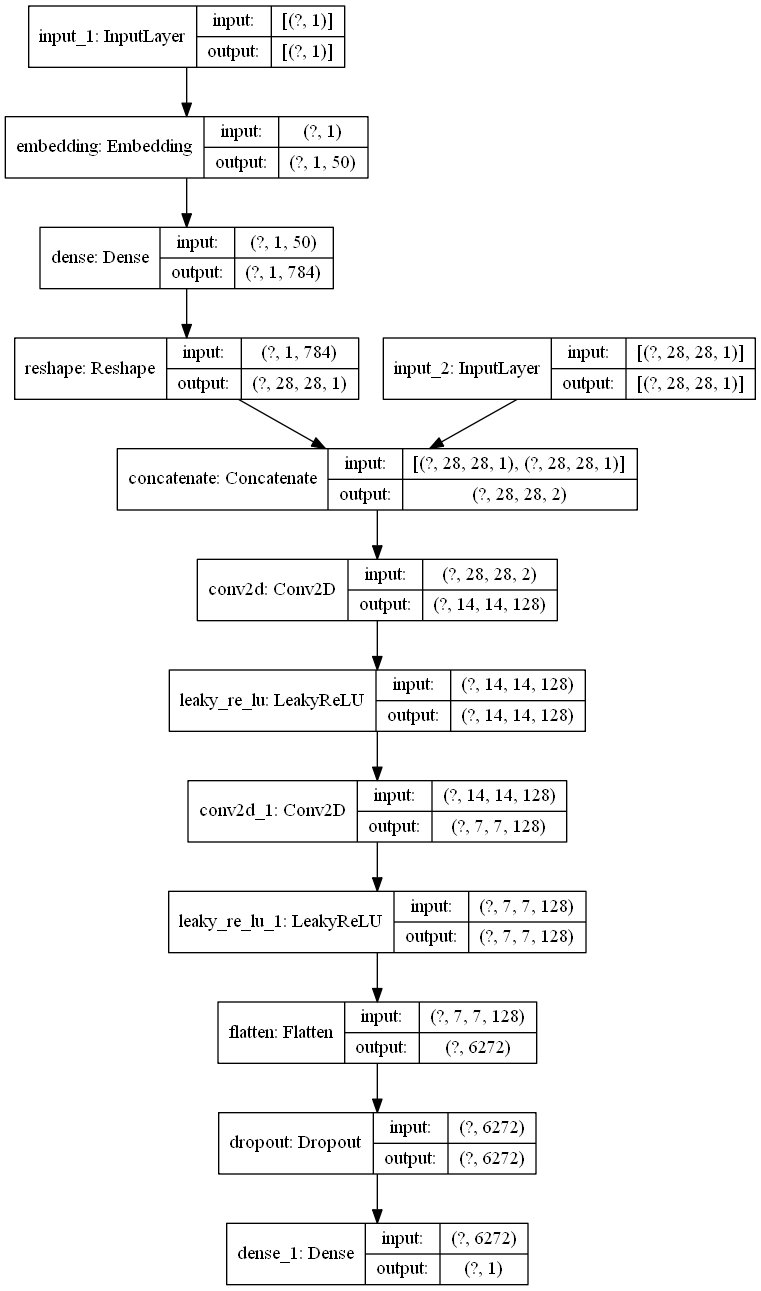

In [10]:
discriminator = define_discriminator(in_shape, n_classes)
discriminator.summary()
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
_______________________________________________________________________________________

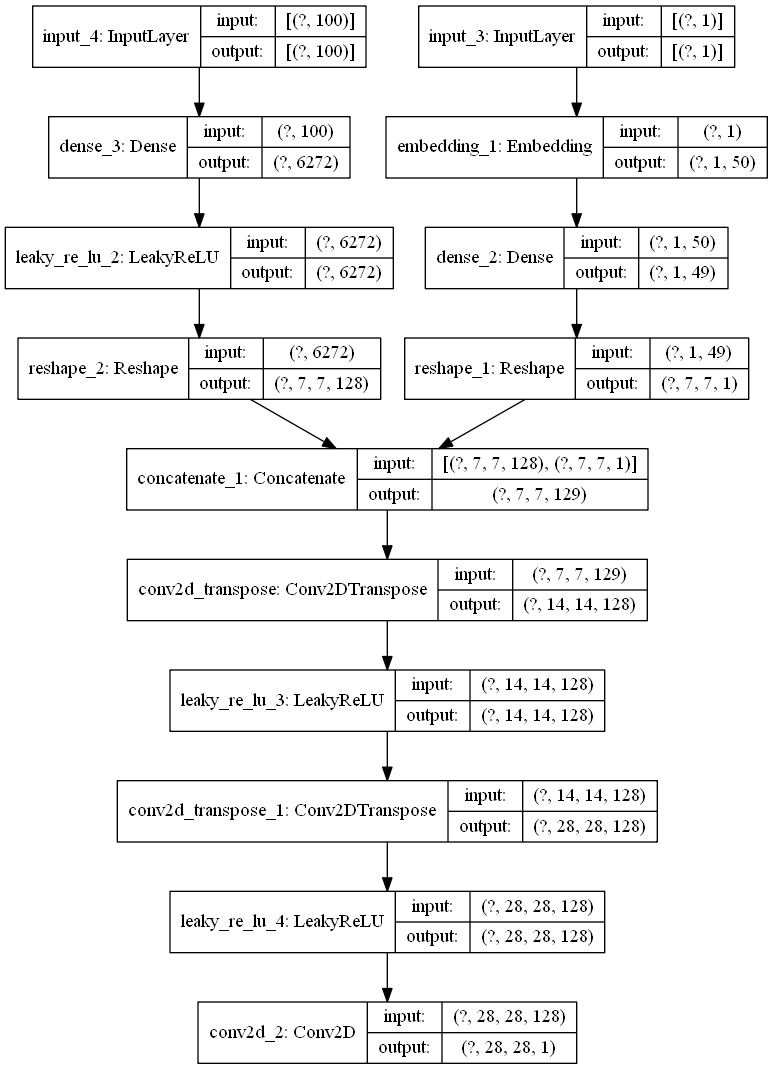

In [11]:
generator = define_generator(latent_dim, n_classes)
generator.summary()
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
_______________________________________________________________________________________

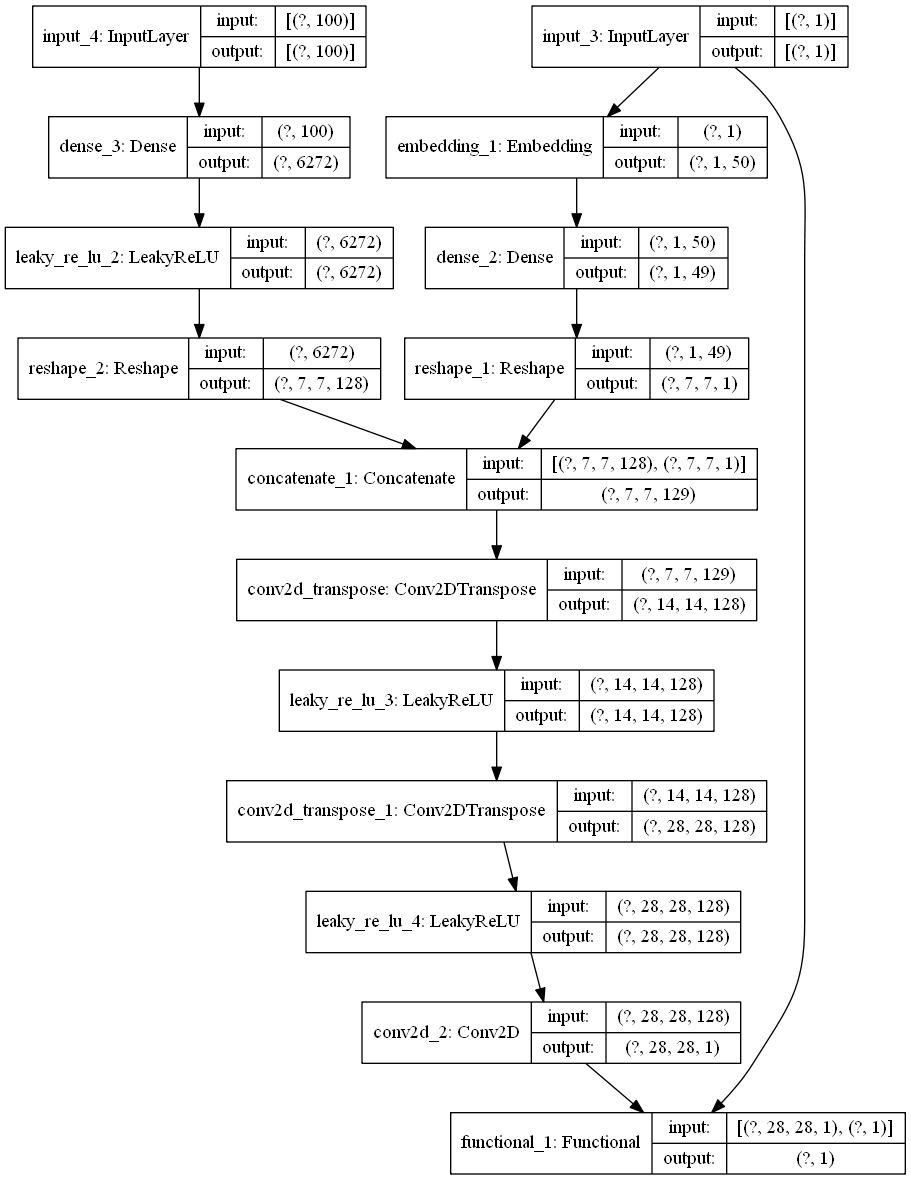

In [12]:
gan = define_gan(generator, discriminator)
gan.summary()
plot_model(gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## Training function

In [13]:
# we need to now provide the class labels to the generator 
# and discriminator directly. We also need to apply
# the label smoothing and image noise. 


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
    #bat_per_epo = int(dataset[0].shape[0] / n_batch)
    bat_per_epo = 150
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    g_model.save('cgan_generator.h5')

## Training

We are now ready to fit the GAN models.

In [14]:
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/150, d1=0.712, d2=0.696 g=0.691
>1, 2/150, d1=0.638, d2=0.700 g=0.687
>1, 3/150, d1=0.584, d2=0.707 g=0.680
>1, 4/150, d1=0.526, d2=0.719 g=0.670
>1, 5/150, d1=0.477, d2=0.736 g=0.656
>1, 6/150, d1=0.435, d2=0.759 g=0.638
>1, 7/150, d1=0.391, d2=0.788 g=0.620
>1, 8/150, d1=0.359, d2=0.821 g=0.607
>1, 9/150, d1=0.337, d2=0.828 g=0.616
>1, 10/150, d1=0.344, d2=0.816 g=0.638
>1, 11/150, d1=0.322, d2=0.762 g=0.706
>1, 12/150, d1=0.338, d2=0.686 g=0.801
>1, 13/150, d1=0.360, d2=0.601 g=0.894
>1, 14/150, d1=0.345, d2=0.533 g=1.006
>1, 15/150, d1=0.344, d2=0.459 g=1.133
>1, 16/150, d1=0.337, d2=0.413 g=1.181
>1, 17/150, d1=0.336, d2=0.436 g=1.125
>1, 18/150, d1=0.321, d2=0.520 g=0.956
>1, 19/150, d1=0.311, d2=0.622 g=0.828
>1, 20/150, d1=0.256, d2=0.722 g=0.733
>1, 21/150, d1=0.312, d2=0.827 g=0.661
>1, 22/150, d1=0.289, d2=0.869 g=0.640
>1, 23/150, d1=0.217, d2=0.870 g=0.638
>1, 24/150, d1=0.249, d2=0.864 g=0.645
>1, 25/150, d1=0.248, d2=0.852 g=0.659
>1, 26/150, d1=0.164, d2=0.819 g=0

## Model: Testing and Running

In [16]:
from numpy import asarray
from tensorflow.keras.models import load_model

In [25]:
def save_plot(examples, n):
    # plot images
    fig, ax = plt.subplots(figsize=(10, 10))
    for i in range(n * n):
        # define subplot
        
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

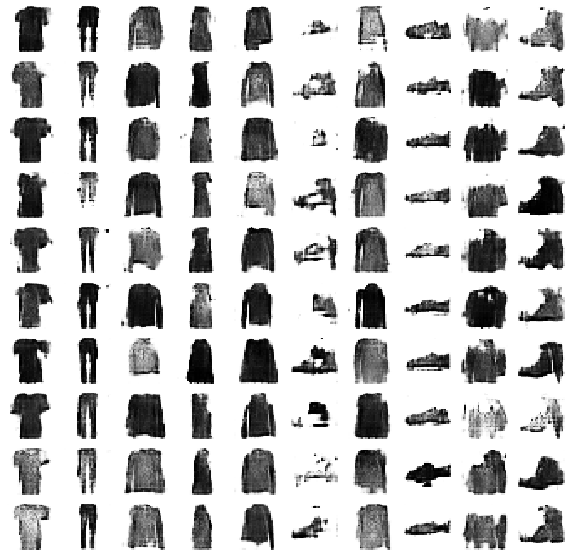

In [26]:
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

Running the example creates a plot of 100 randomly generated items of clothing arranged into a 10×10 grid.